In [1]:
import numpy as np
from collections import namedtuple
import sys
from typing import List, Tuple, Dict, Set, Union
import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torchnlp.nn import Attention
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from nltk import word_tokenize
import pickle
from model_embeddings import ModelEmbeddings
from evaluator import Evaluator
from vocab import Vocab, VocabEntry
from utils import read_corpus, pad_sents, batch_iter

[nltk_data] Downloading package punkt to /Users/yuloucn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import fasttext
import fasttext.util
ft = fasttext.load_model('../data/cc.en.300.bin')
print(ft.get_dimension())
fasttext.util.reduce_model(ft, 100)
print(ft.get_dimension())

300
100


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
print(ft.get_word_vector('nihao'))
print(ft.get_nearest_neighbors('changsha'))

[-0.11151148 -0.04900418  0.0288552   0.04092126  0.19804892  0.00216246
  0.03674458  0.09451544 -0.12428932  0.0465628  -0.1439622   0.17689864
  0.05874445 -0.07696565  0.03921199 -0.03626664  0.02874357  0.07096066
  0.05633339  0.17098126  0.01038988  0.14626968 -0.1002604   0.07075594
  0.03674031  0.03039704 -0.0011446   0.00437543 -0.07224936 -0.04147346
  0.04753026  0.01315587 -0.0048466  -0.00099305 -0.08950087 -0.06880744
 -0.03843674 -0.04456125 -0.02063351  0.05325395 -0.07706098 -0.04812273
 -0.03669549 -0.0366352  -0.02296097 -0.02639301 -0.0252313   0.04095381
 -0.0153988  -0.06415159  0.00408742  0.05854311 -0.03529252  0.01532949
 -0.02925256 -0.09079327  0.02499075  0.0022867  -0.06236723 -0.06313032
  0.02734467 -0.08804032 -0.01031698 -0.02277267 -0.06588884  0.0024988
  0.0450968   0.03720963 -0.01330832 -0.03214228 -0.03183099 -0.01358417
  0.04029506  0.06616739  0.00523137 -0.01328973  0.01361618  0.03699441
  0.02201992 -0.03893679 -0.04548992  0.02037135  0.

In [36]:
definitions = []
unparsed_definition = []
words = []
src_sents = read_corpus('../data/data_train_definitions.txt')

In [37]:
with open('../data/data_train_words.txt') as f:
    words += f.read().splitlines()
    
with open('../data/data_train_definitions.txt') as f:
    unparsed_definition += f.read().splitlines()
    definitions += [word_tokenize(a) for a in unparsed_definition]

training_data = [(definitions[i], words[i]) for i in range(len(words))]

In [45]:
train, valid, test = pickle.load(open("../data/train_valid_test.data", "rb"))

unparsed_definition = [t[1] for t in train]
definitions = [word_tokenize(a) for a in unparsed_definition]
words = [t[0] for t in train]

In [46]:
eval = Evaluator()
# fasttext_dict = eval.load_vectors(fname ="../data/wiki-news-300d-1M-subword.vec", max_line = 10000000)
fasttext_dict = {}
sub_fasttext_dict = {}
#only train words in the dictionary
for i in range(len(words)-1, -1, -1):
    fasttext_dict[words[i]] = ft.get_word_vector(words[i])
    sub_fasttext_dict[words[i]] = fasttext_dict[words[i]]
        
# high_freq_dict = eval.load_vectors(fname ="../data/wiki-news-300d-1M-subword.vec", max_line = 30000)
# sub_fasttext_dict.update()

src_sents = read_corpus('../data/data_train_definitions.txt')
vocab = VocabEntry.from_corpus(definitions, 1000000, 0)
    
print(len(vocab))

for w in words:
    vocab.add(w)
print(len(vocab))

number of word types: 34192, number of word types w/ frequency >= 0: 34192
34196
63294


In [47]:
import pickle
with open("../data/words_defs_dict.train", "wb") as f:
    pickle.dump((words, definitions, sub_fasttext_dict), f)

In [48]:
assert(len(words) == len(definitions))
training_data = [(definitions[i], words[i]) for i in range(len(words))]

In [49]:
def create_emb_layer(weights_matrix, src_pad_token_idx, device = "cpu", non_trainable=True):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, src_pad_token_idx)
    emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix).float().to(device)) #figure out what is here
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

class ModelEmbeddings(nn.Module): 
    """
    Class that converts input words to their embeddings.
    """

    def __init__(self, embed_size, vocab, fasttext_model):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (VocabEntry)
        """
        super(ModelEmbeddings, self).__init__()

        self.embed_size = embed_size

        matrix_len = len(vocab)
        weights_matrix = np.zeros((matrix_len, self.embed_size))
        words_found = 0
        #print(len(vocab), weights_matrix.shape)
        for word, index in vocab.word2id.items():
            weights_matrix[index] = np.array(fasttext_model.get_word_vector(word))
        
#         for word, index in vocab.word2id.items():
#             try:
#                 weights_matrix[index] = np.array(fasttext_dict[word])
#                 words_found += 1
#             except KeyError:
#                 weights_matrix[index] = np.random.normal(scale=0.6, size=(self.embed_size,))

        # default values
        src_pad_token_idx = vocab['<pad>']
        self.source = create_emb_layer(weights_matrix, src_pad_token_idx, device, True)

In [42]:
# class GRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, vocab, fasttext_dict):
#         super(GRUModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.embedding = ModelEmbeddings(input_size, vocab, fasttext_dict)
#         self.gru = nn.GRU(input_size, hidden_size)
        
#         self.linear = nn.Linear(self.hidden_size, self.hidden_size, bias = True)

#     def forward(self, input_, hidden, lengths , dropout_rate = 0.3):
#         embedded = self.embedding.source[0](input_)
#         embedded = pack_padded_sequence(embedded, lengths)
#         output, hidden = self.gru(embedded, hidden)
#         dropout = nn.Dropout(dropout_rate)
#         hidden_dropped = dropout(hidden.permute(1,0,2)) # you dont need dropout in validation
#         projected = self.linear(hidden_dropped)
#         return projected, hidden

#     def initHidden(self, batch_size, device = None):
#         return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [89]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab, fasttext_model):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.vocab = vocab
        self.embedding = ModelEmbeddings(input_size, vocab, fasttext_model)
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional = True)
        self.linear = nn.Linear(self.hidden_size * 2, self.hidden_size, bias = True)
        self.linear2 = nn.Linear(self.hidden_size, self.hidden_size, bias = True)
        self.attention = Attention(self.hidden_size)

    def forward(self, input_, hidden, lengths, dropout_rate = 0.3):
        embedded = self.embedding.source[0](input_)
        embedded = pack_padded_sequence(embedded, lengths)
        output, (h_n, c_n) = self.lstm(embedded)   
        hidden_permuted = h_n.contiguous().view(1, -1, self.hidden_size * 2).permute(1,0,2)
         
        projected = self.linear(hidden_permuted)
        dropout = nn.Dropout(dropout_rate)
        projected_dropped = dropout(projected)
        projected2 = self.linear2(projected_dropped)
        return projected2, hidden

    def initHidden(self, batch_size, device = None):
        return torch.zeros(1, batch_size, self.hidden_size, device = device)

In [90]:
model = LSTMModel(100, 100, vocab, ft)
loss_function = nn.CosineEmbeddingLoss(margin=0.0, reduction='mean')
l1loss = nn.L1Loss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [45]:
# model = GRUModel(50, 50, vocab, fasttext_dict)
# loss_function = nn.L1Loss(reduction = "sum")
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

0 tensor(0.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)
100 tensor(0.0013, dtype=torch.float64, grad_fn=<MeanBackward0>)
200 tensor(0.0021, dtype=torch.float64, grad_fn=<MeanBackward0>)
300 tensor(0.0030, dtype=torch.float64, grad_fn=<MeanBackward0>)
400 tensor(0.0009, dtype=torch.float64, grad_fn=<MeanBackward0>)
500 tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
600 tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
700 tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
800 tensor(0.0027, dtype=torch.float64, grad_fn=<MeanBackward0>)
900 tensor(0.0015, dtype=torch.float64, grad_fn=<MeanBackward0>)
Time:  10.614251816063188
53079
torch.Size([8, 100])
['batting', 'bowler', 'bowlers', 'batsmen', 'innings', 'outfield', 'batted', 'batsman', 'bat', 'bowling']
batting ['batting', 'bowler', 'bowlers', 'batsmen', 'innings', 'outfield', 'batted', 'batsman', 'bat', 'bowling']
['drifted', 'crept', 'slipped', 'drifting', 'veered', 'clung', 'retreated', 'me

KeyboardInterrupt: 

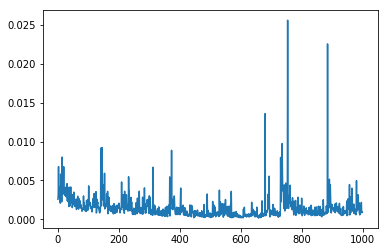

In [100]:
#check overfit

definition_indices = vocab.words2indices(definitions)
words_in = 0
words_out = 0

import timeit
start = timeit.default_timer()
losses = []

batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

loss_function = nn.CosineEmbeddingLoss(margin=0.0, reduction='mean')
#loss_function = nn.L1Loss(reduction='none')

for src_sents, tgt_word in batch_iter(training_data, batch_size, False):
    for i in range(1000):
        model.zero_grad()
        x_lengths = [len(sent) for sent in src_sents]
        x = vocab.to_input_tensor(src_sents, "cpu")
        init_hidden = model.initHidden(len(src_sents), "cpu")
        tag_scores = model.forward(x, init_hidden, x_lengths)
        y_indices = vocab.words2indices(tgt_word)
        y_array = model.embedding.source[0](torch.tensor(y_indices, device = device)).double()
        y_pred = tag_scores[0].squeeze(dim = 1).double()
        y_match = torch.ones(y_pred.shape[0])
        loss = loss_function(y_pred, y_array, y_match)
        #print(y_pred.shape, y_match.shape, loss.shape, loss)
        loss.backward()
        optimizer.step() 
        losses.append(loss)
        if i % 100 == 0:
            print(i, loss)
    break
    
stop = timeit.default_timer()

print('Time: ', stop - start)

import matplotlib.pyplot as plt
print(plt.plot([l.double() for l in losses][:1200]))

model.zero_grad()
x_lengths = [len(sent) for sent in src_sents]
x = vocab.to_input_tensor(src_sents, "cpu")
init_hidden = model.initHidden(len(src_sents), "cpu")
tag_scores = model.forward(x, init_hidden, x_lengths)
y_pred = tag_scores[0].squeeze(dim = 1).double()

validate_dict = dict([(w, model.embedding.source[0](torch.tensor(vocab[w])).numpy()) for w in set(words)])
print(len(validate_dict))

print(y_pred.shape)
for i in range(len(y_pred)):
    eval.top_ten_hundred(validate_dict, tgt_word[i], y_pred[i].detach().numpy())

In [73]:
definition_indices = vocab.words2indices(definitions)
words_in = 0
words_out = 0

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

import timeit
start = timeit.default_timer()
losses = []

batch_size = 8

for epoch in range(5000):
    for src_sents, tgt_word in batch_iter(training_data, batch_size, False):
        model.zero_grad()
        x_lengths = [len(sent) for sent in src_sents]
        x = vocab.to_input_tensor(src_sents, device)
        init_hidden = model.initHidden(len(src_sents), device)
        tag_scores = model.forward(x, init_hidden, x_lengths)
        y_array = model.embedding.source[0](torch.tensor(vocab.words2indices(tgt_word))).double()
        y_pred = tag_scores[0].squeeze(dim = 1).double()
        y_match = torch.ones(1,)
        #loss = loss_function(y_pred, y_array, y_match)
        loss = l1loss(y_pred.transpose(0,1), y_array.transpose(0,1))
        loss.backward()
        optimizer.step()
    losses.append(loss)
    print(epoch, loss, timeit.default_timer() - start)
    
stop = timeit.default_timer()

print('Time: ', stop - start)

import matplotlib.pyplot as plt
print(plt.plot([l.double() for l in losses]))

RuntimeError: The size of tensor a (8) must match the size of tensor b (100) at non-singleton dimension 1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(plt.plot([l.double() for l in losses]))

In [ ]:
model.zero_grad()
x_lengths = [len(sent) for sent in src_sents]
x = vocab.to_input_tensor(src_sents, device)
init_hidden = model.initHidden(len(src_sents), device)
tag_scores = model.forward(x, init_hidden, x_lengths)
y_pred = tag_scores[0].squeeze(dim = 1).double()

validate_dict = dict([(w, model.embedding.source[0](torch.tensor(vocab[w])).detach().numpy()) for w in set(words)])
print(len(validate_dict))

print(y_pred.shape)
for i in range(len(y_pred)):
    eval.top_ten_hundred(validate_dict, tgt_word[i], y_pred[i].detach().numpy())